In [58]:
import numpy as np
import struct
import os

In [83]:
# create list of devices and their signal identifiers (ZFC id M_zfc)
# device_list = ["32C793E", "32C79BE", "32C7981", "32B172B", "32B1708", "32B1728", "32C7920", "32C79C6"]
device_list = ["32C793E", "32B1708", "32C79C6"]
# M_list = [31, 73, 109, 139, 97, 173, 211, 229]
M_list = [31, 97, 229]
N = 257

In [84]:
## cleck logfiles to find which runs and devices failed
MC_runs = 10
run_success = np.zeros((len(device_list), MC_runs), dtype=bool)
LogFolder = "/home/nuc/OTA-C/shell/LogFolder"

for logfile in os.listdir(LogFolder):
    logpath = os.path.join(LogFolder, logfile)

    if os.path.isfile(logpath):
        device_id = logfile.split("_")[-2]
        run_id = int(logfile.split("_")[-1].split(".")[0])
        # print(logfile, device_id, run_id)
        with open(logpath, 'r') as f:
            lines = f.readlines()
            last_line = lines[-1]
            if (last_line.startswith("Transmitted")):
                dev_id_num = device_list.index(device_id)
                run_success[dev_id_num, run_id] = True
            else:
                if (device_id in device_list):
                    print("Failed for ", device_id, " run ", run_id)


Failed for  32C79C6  run  2
Failed for  32C793E  run  5


In [85]:
samples_all = []
for i in range(MC_runs):
    file_path = "./storage/new_mc_run_%d_data.dat" %i
    sample_size = 8
    try:
        with open(file_path, 'rb') as f:
            # Read the binary data
            binary_data = f.read()
    except:
        print("File %s not found!"%file_path)
        continue

    num_samples = len(binary_data) // sample_size
    samples = []
    for i in range(num_samples):
        # Extract real and imaginary parts from the binary data
        real_part, imag_part = struct.unpack('ff', binary_data[i * sample_size: (i + 1) * sample_size])
        # Create a complex number and append it to the list of samples
        samples.append(complex(real_part, imag_part))

    samples = np.array(samples)
    samples_all.append(samples)

print(samples_all[0].shape)

(1028,)


In [86]:
N = 257

zfc_seq_list = [np.array([np.exp(-1j * np.pi * M * n * (n + 1) / N) for n in range(N)]) for M in M_list]

10


10it [00:00, 5458.49it/s]

Tvar 31 0 561.5555555555555 426.91358024691357
Tvar 97 1 565.4 1033.44
Tvar 229 2 573.2222222222222 5.061728395061728


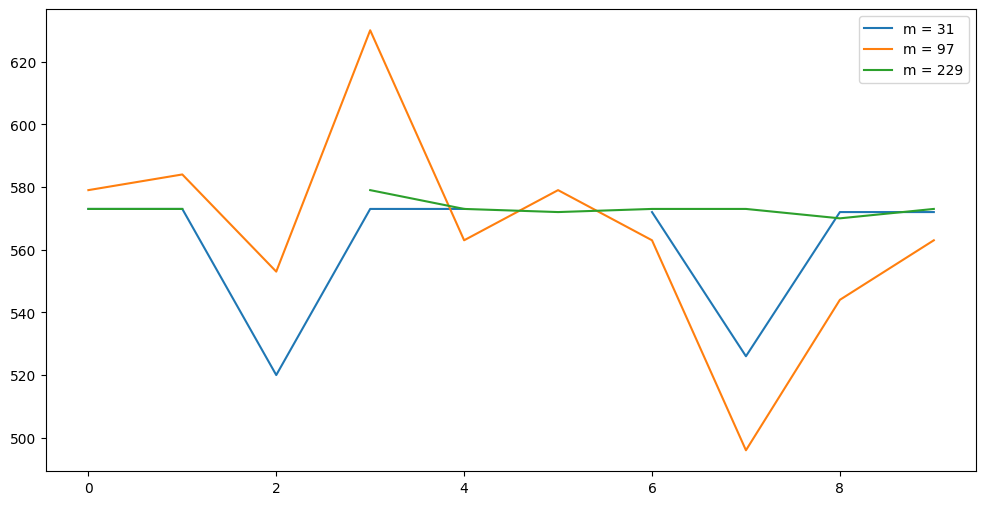

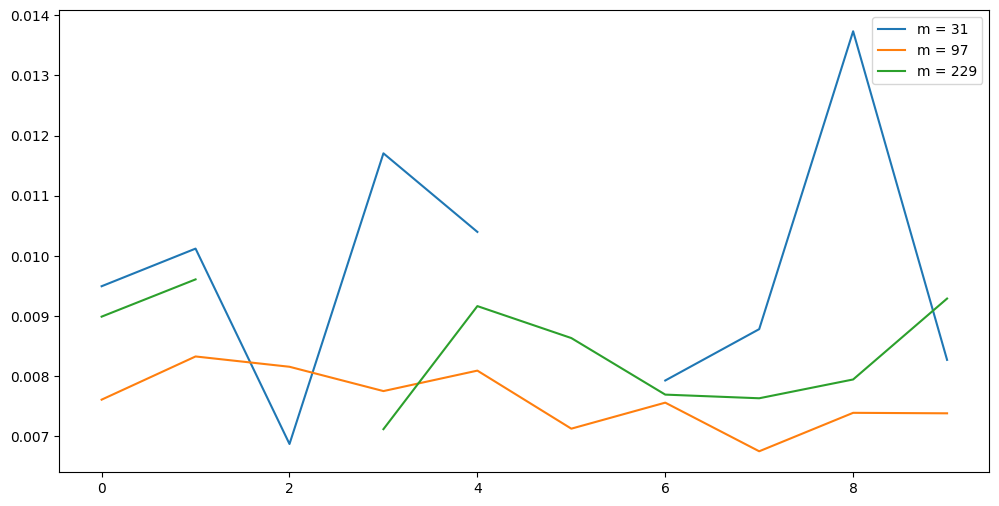

In [87]:
from tqdm import tqdm
from matplotlib import pyplot as plt

print(len(samples_all))

fig, ax = plt.subplots(figsize=[12, 6])
fig2, ax2 = plt.subplots(figsize=[12, 6])
timing_arr = np.zeros((len(samples_all), len(M_list)))
vals_arr = np.zeros((len(samples_all), len(M_list)))
for n, samples in tqdm(enumerate(samples_all)):
    corr_zfc_list = np.array([np.correlate(samples, zfc_seq, mode='valid') / N for zfc_seq in zfc_seq_list])
    for i in range(len(M_list)):
        # if (M_list[i] == 139):
        #     continue
        if (run_success[i, n] == True):
            timing_arr[n, i] = np.argmax(np.abs(corr_zfc_list[i])).item()
            vals_arr[n, i] = np.max(np.abs(corr_zfc_list[i])).item()
        else:
            timing_arr[n, i] = np.nan
            vals_arr[n, i] = np.nan

for i in range(len(M_list)):
    # if (M_list[i] == 139):
    #     continue
    timing = timing_arr[:, i]
    tmean, tvar = np.nanmean(timing), np.nanvar(timing)
    print("Tvar %d %d"%(M_list[i], i), tmean, tvar)
    plot_timing = timing
    # plot_timing = np.where(np.abs(timing - tmean) < 50, timing, np.nan)
    # if np.abs(np.min(timing) - tmean) < 50:
    #     print(plot_timing[i])
    # tmean, tvar = np.mean(plot_timing), np.var(plot_timing)
    # print("plot Tvar %d"%i, tmean, tvar)
    ax.plot(np.arange(len(samples_all)), plot_timing, label="m = %d"%M_list[i])
    ax2.plot(np.arange(len(samples_all)), vals_arr[:, i], label="m = %d"%M_list[i])

ax.legend()
ax2.legend()
# for i in range(len(M_list)):
#     print("%d -- %.5e" %(np.argmax(np.abs(corr_zfc_list[i])).item(), np.max(np.abs(corr_zfc_list[i])).item()))

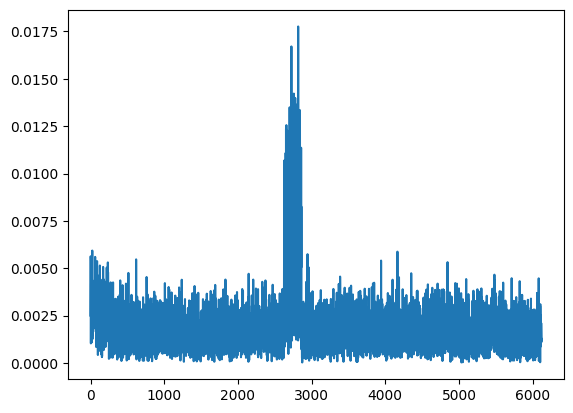

In [8]:
from matplotlib import pyplot as plt
plt.plot(np.abs(samples))

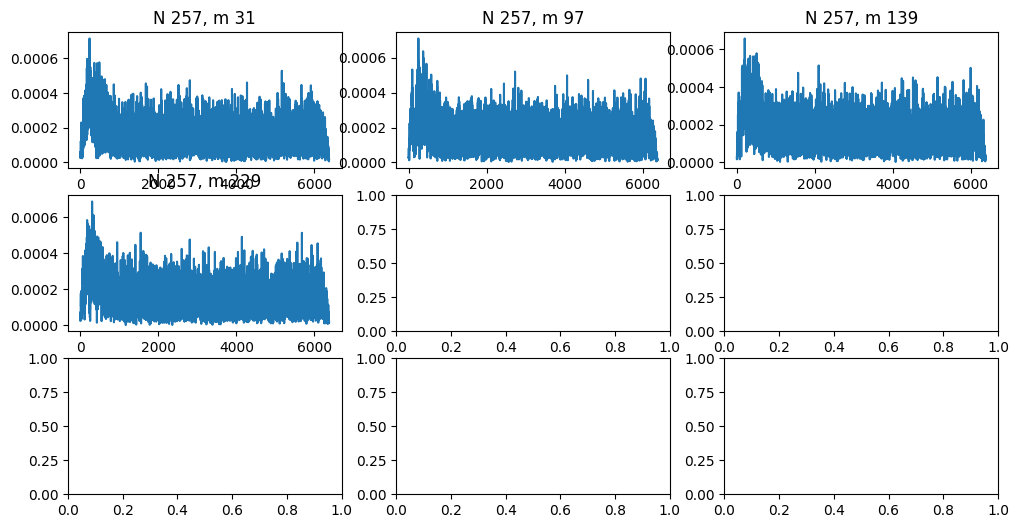

In [57]:
plot_data_list = [np.abs(corr_zfc) for corr_zfc in corr_zfc_list]

fig, ax = plt.subplots(3, 3, figsize=[12,6])
axs = ax.flatten()
for i in range(len(M_list)):
    axs[i].plot(plot_data_list[i])
    axs[i].set_title("N %d, m %d" %(N, M_list[i]))

# print(np.diff(np.argwhere(plot_data > 60.0).squeeze()))
# print(plot_data[np.argwhere(plot_data > 60.0).squeeze()])


In [ ]:
# floating window - to find the threshold
window_len = N
relevant_signal = np.abs(samples[pmax-5*N : pmax + 5*N])
ma_signal = np.zeros((relevant_signal.size - N + 1), dtype=float)
for i in range(ma_signal.size):
    for j in range(N):
        ma_signal[i] += relevant_signal[i + j]
    ma_signal[i] /= N
plt.plot(ma_signal)
print(np.max(ma_signal))
pp = np.argmax(ma_signal).squeeze()
print(np.mean(ma_signal))
print(np.mean(np.delete(ma_signal, np.arange(pp - N//2 - 1, pp + N//2 + 1))))
# plt.yscale("log")